In [86]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import os
import copy

import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import pennylane

In [87]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

Transforms

In [88]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

In [89]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

Importing data

In [90]:
batch_size = 4 

In [91]:
data_dir = 'hymenoptera_data/'
sets = ['train', 'val']

image_datasets = {set: datasets.ImageFolder(os.path.join(data_dir, set),
                                          data_transforms[set])
                  for set in sets}

train_loader = torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size,
                                             shuffle=True, num_workers=2)

test_loader = torch.utils.data.DataLoader(image_datasets['val'], batch_size=batch_size,
                                             shuffle=True, num_workers=2)

dataset_sizes = {set: len(image_datasets[set]) for set in sets}
classes = image_datasets['train'].classes
classes

['ants', 'bees']

In [92]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [93]:
losses = list()
def train(model, train_loader, criterion, optimizer, num_epochs=100):
    for epoch in range(num_epochs):
        running_loss = 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            output = model(images)
            loss = criterion(output, labels)
            running_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        #scheduler.step()
        losses.append(running_loss)
        print(f"Epoch {epoch + 1} / {num_epochs}")
    print('Training is finished')
    return model

In [101]:
def predict(model, test_loader, batch_size=batch_size):
  n_samples = 0
  n_correct = 0
  n_class_samples = np.zeros(2)
  n_class_correct = np.zeros(2)
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    with torch.no_grad():
      output = model(images)
    _, predictions = torch.max(output, -1)
    n_samples += labels.size(0)
    n_correct += (predictions==labels).sum().item()
    
    for i in range(images.shape[0]):
      label = labels[i]
      pred = predictions[i]
      if (label == pred):
        n_class_correct[label] += 1
      n_class_samples[label] += 1

  acc = 100.0 * n_correct / n_samples
  print(f'Accuracy of the network: {acc} %')

  for i in range(2):
    acc = 100.0 * n_class_correct[i] / n_class_samples[i]
    print(f'Accuracy of {classes[i]}: {acc} %')

In [103]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)
model = train(model, train_loader, criterion, optimizer, num_epochs=50)

c:\Users\egorm\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\egorm\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1 / 50
Epoch 2 / 50
Epoch 3 / 50
Epoch 4 / 50
Epoch 5 / 50
Epoch 6 / 50
Epoch 7 / 50
Epoch 8 / 50
Epoch 9 / 50
Epoch 10 / 50
Epoch 11 / 50
Epoch 12 / 50
Epoch 13 / 50
Epoch 14 / 50
Epoch 15 / 50
Epoch 16 / 50
Epoch 17 / 50
Epoch 18 / 50
Epoch 19 / 50
Epoch 20 / 50
Epoch 21 / 50
Epoch 22 / 50
Epoch 23 / 50
Epoch 24 / 50
Epoch 25 / 50
Epoch 26 / 50
Epoch 27 / 50
Epoch 28 / 50
Epoch 29 / 50
Epoch 30 / 50
Epoch 31 / 50
Epoch 32 / 50
Epoch 33 / 50
Epoch 34 / 50
Epoch 35 / 50
Epoch 36 / 50
Epoch 37 / 50
Epoch 38 / 50
Epoch 39 / 50
Epoch 40 / 50
Epoch 41 / 50
Epoch 42 / 50
Epoch 43 / 50
Epoch 44 / 50
Epoch 45 / 50
Epoch 46 / 50
Epoch 47 / 50
Epoch 48 / 50
Epoch 49 / 50
Epoch 50 / 50
Training is finished


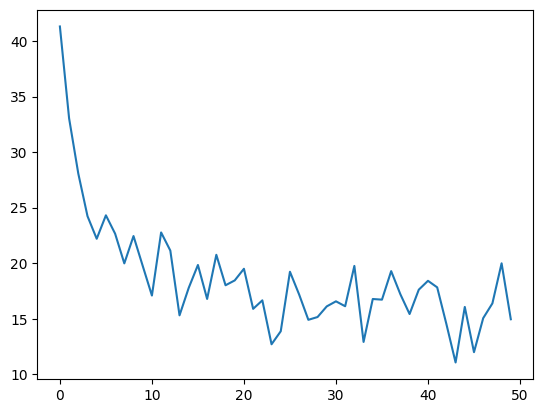

In [107]:
plt.plot(np.arange(len(losses)), losses)
plt.show()

In [108]:
predict(model, test_loader, batch_size=batch_size)

Accuracy of the network: 88.23529411764706 %
Accuracy of ants: 97.14285714285714 %
Accuracy of bees: 80.72289156626506 %
